#### This script will perform CRF Differences and save them as a dict -> .pkl file
#### 1| save diffferce parameters: per contrast per harmonic in a post - pre manner
#### 2| plot data - make sure there is a yline at 0 to represnt the differnces - or plot this in a seperate plot
#### 3| maybe compute the statistical differnce between the data and save vals too - or in another script - we'll see
####  4| maybe find the error bars? 


In [2]:
# load packages
import numpy as np 
from scipy.io   import  loadmat
import pandas as pd
import os
import matplotlib.pyplot as plt #import matplotlib as plt
from scipy.optimize import curve_fit 
import seaborn as sns #import mat73
import pickle as pkl
from datetime import datetime

In [3]:
NumBins = 6 # number of contrasts
NumHarms = 2 # number of harmonic data: 2F1, 4F1
NumComp = 0 # first component from RCA
NumConds = 4
diff_ax = np.arange(0,NumBins) # plot differences

In [16]:
cp1 = sns.color_palette("cubehelix",12)# dark to light
cp2 = sns.color_palette("hls",12)
sns.set_theme(context='notebook', style = 'darkgrid', palette=cp1)

In [5]:
# Main Directory of processed file from MatLab
MainDir = 'D:\\AttnXV3_analysis\\RCA_F1\\AvgCRFs\\' # set dir
os.chdir(MainDir) # change old dir, to this dir
d = os.listdir(MainDir) # list files in dir
print(f'Files on hand: {d}')
##############################################
FileN = d[-1] # choose one                        
file_path1 = os.path.join(MainDir, FileN) # join paths and prep 2 load
print('Current WD:',file_path1) # does path exist ... ?
print('Does File #1 Exist?',os.path.exists(file_path1)) # yes or no

Files on hand: ['AllCondCRF_AllSess_20240212_1128.pkl', 'AllCondCRF_AllSess_20240213_1141.pkl']
Current WD: D:\AttnXV3_analysis\RCA_F1\AvgCRFs\AllCondCRF_AllSess_20240213_1141.pkl
Does File #1 Exist? True


In [6]:
loadData = pkl.load(open(file_path1,'rb'))
print(loadData.keys())

dict_keys(['Data', 'SubNames', 'VoiceMemo', 'DictMainKeys', 'ContLevs', 'crfLabs'])


In [7]:
data = loadData['Data']
data_labels = loadData['DictMainKeys']
SubNames = np.array(loadData['SubNames'])
note = loadData['VoiceMemo']
contrast_levels = loadData['ContLevs']
contrast_labs = loadData['crfLabs']
print(note)
NumSubs = int(len(SubNames))
print(data_labels) # labels for nr plots

['This file contains all subjects who did both sessions, avg of CRF [12x2] array, original crfs']
['attnL F1', 'attnL F2', 'attnR F1', 'attnR F2']


#### Functions

In [8]:
#sns.set_theme()
def GetDiffs(NumSubs, dictIn):
    """
    Get All post - pre amplitude differnces cross conditions and contrasts
    dictIn = key of dict data
    """
    aOut = np.zeros((NumSubs,NumBins*2)) # 55 x 12 
    for su in range(NumSubs):
        aIn = dictIn[su]
        AllDiffs = aIn[:,1] - aIn[:,0]
        aOut[su,:] = AllDiffs
    return aOut # 12x1 arry [0:6] 2f, [6:12] 4f

In [9]:
AllDiffs  = {} # 4 [nsubj * 12 array]
for co in range(NumConds):  
    AllDiffs[co] = GetDiffs(NumSubs,data[co])
    print(AllDiffs[co].shape)

(25, 12)
(25, 12)
(25, 12)
(25, 12)


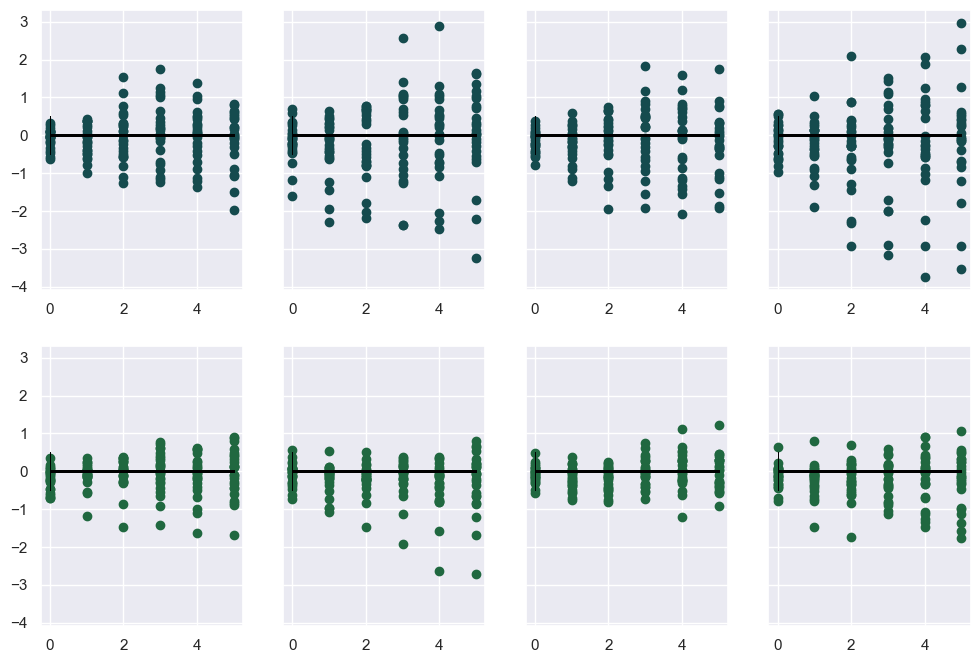

In [19]:
fig,axs = plt.subplots(2,NumConds,figsize = (12,8), sharey = True)

for co in range(NumConds):
    for su in range(NumSubs):
        axs[0,co].scatter(diff_ax,AllDiffs[co][su,:6], color = cp1[2])
        axs[0,co].hlines(0, xmin = 0, xmax = 5, color = 'black',linewidth = 1)
        axs[0,co].vlines(0, ymin = -1/2, ymax = 1/2, color = 'black',linewidth = 1/2)

        axs[1,co].scatter(diff_ax,AllDiffs[co][su,6:],color = cp1[3])
        axs[1,co].hlines(0, xmin = 0, xmax = 5, color = 'black',linewidth = 1)
        axs[1,co].vlines(0, ymin = -1/2, ymax = 1/2, color = 'black',linewidth = 1/2)

In [124]:
AvgDiffs = {}

for co in range(NumConds):
    AvgDiffs[co] = np.mean(AllDiffs[co],axis = 0)

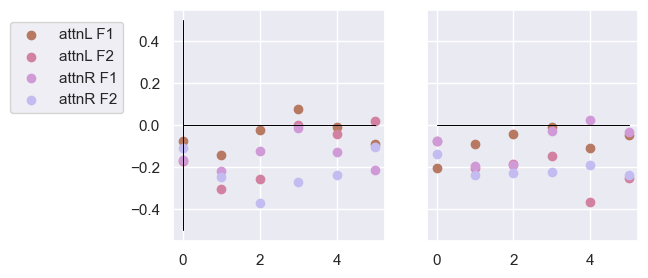

In [175]:
fig,axs = plt.subplots(1,2,figsize=(6,3),sharey=True, sharex = True)
for i in range(NumConds):
    axs[0].scatter(diff_ax,AvgDiffs[i][:6], label = f'{data_labels[i]}', color = cp1[i+6])
    axs[1].scatter(diff_ax,AvgDiffs[i][6:], label = f'{data_labels[i]}', color = cp1[i+6])

    axs[0].hlines(0,xmin=0,xmax=5,color='black',linewidth = 1/2)
    axs[1].hlines(0,xmin=0,xmax=5,color='black',linewidth = 1/2)
    axs[0].vlines(0,ymin=-1/2,ymax=1/2,color ='black',linewidth=1/2)

axs[0].legend(loc = 'upper right',fontsize=9)
axs[0].legend(loc='upper right', bbox_to_anchor=(-0.2, 0.98))